# Homework 04

## 1. Import

### 1.1 Import packages 

In [1]:
# import standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


### 1.2 Import data

In [2]:
# variable data
df = pd.read_csv("data/bank-full.csv", delimiter=';')

## 2. Data preparation

### 2.1 Selecting a subset of columns

In [3]:
# select a subset of columns
col = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

In [4]:
# Reducing the dataset
df = df[col]

### 2.2 Splitting the data

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
# creating a validation set
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
# reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
# defining the target variable
y_train = df_train.y.values
y_val = df_val.y.values

In [8]:
# deleting the target variable from the data
del df_train['y']
del df_val['y']

## 3. Questions

### 3.1 Question 1
Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous


In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
numerical_vars = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

for var in numerical_vars:
    auc = roc_auc_score(y_train, df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    auc_scores[var] = auc

# Find the variable with the highest AUC
best_var = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_var]

print(f"The numerical variable with the highest AUC is {best_var} with an AUC of {best_auc:.3f}")

The numerical variable with the highest AUC is duration with an AUC of 0.815


### 3.2 Question 2

#### Logistic Regression

In [11]:
# creating a dictionary of the data
train_dict = df_train.to_dict(orient='records')

In [12]:
# creating an instance of the DictVectorizer
dv = DictVectorizer(sparse=False)
# fitting the data
X_train = dv.fit_transform(train_dict)
X_train.shape

(27126, 47)

In [13]:
# creating a dictionary of the data
val_dict = df_val.to_dict(orient='records')
# transform the validation data
X_val = dv.transform(val_dict)

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000,random_state=1)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [15]:
score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
print(f"The AUC score of the model is {score:.3f}")

The AUC score of the model is 0.900


### 3.3 Question 3

/Users/zaccaria/.pyenv/versions/3.11.7/envs/h01/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


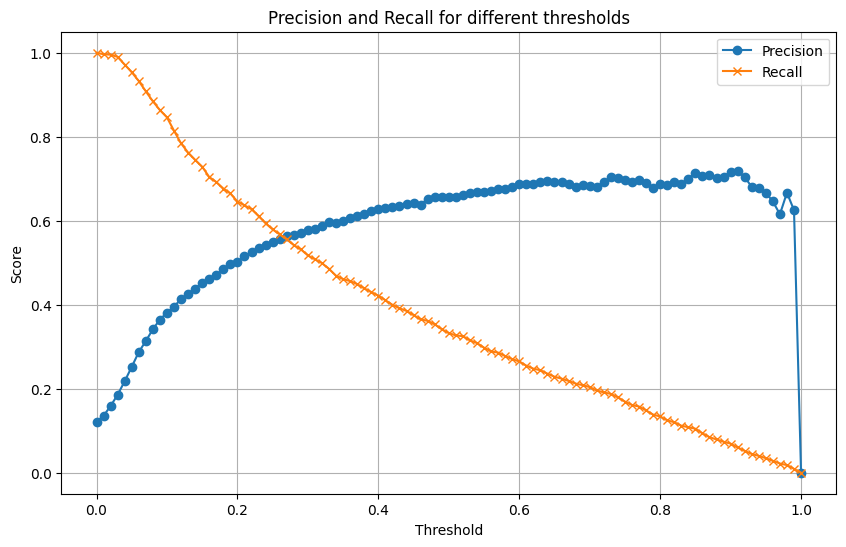

In [16]:
from sklearn.metrics import precision_score, recall_score

# Initialize lists to store precision and recall values
precisions = []
recalls = []

# Convert true labels to binary values
y_val_binary = (y_val == 'yes').astype(int)

# Generate predictions probabilities
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluate precision and recall for each threshold
thresholds = np.arange(0.0, 1.01, 0.01)
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_val_binary, y_pred))
    recalls.append(recall_score(y_val_binary, y_pred))

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='x')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall for different thresholds')
plt.legend()
plt.grid(True)
plt.show()

### 3.4 Question 4

In [17]:
from sklearn.metrics import f1_score

# Generate predictions based on a threshold of 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(y_val_binary, y_pred)
print(f"The F1 score of the model is {f1:.3f}")

The F1 score of the model is 0.441


### 3.5 Question 5

In [18]:
from sklearn.model_selection import KFold

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize lists to store the AUC scores for each fold
auc_scores_kfold = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(df_full_train):
    df_train_kf = df_full_train.iloc[train_index]
    df_val_kf = df_full_train.iloc[val_index]
    
    y_train_kf = df_train_kf.y.values
    y_val_kf = df_val_kf.y.values
    
    del df_train_kf['y']
    del df_val_kf['y']
    
    train_dict_kf = df_train_kf.to_dict(orient='records')
    val_dict_kf = df_val_kf.to_dict(orient='records')
    
    X_train_kf = dv.fit_transform(train_dict_kf)
    X_val_kf = dv.transform(val_dict_kf)
    
    model_kf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model_kf.fit(X_train_kf, y_train_kf)
    
    score_kf = roc_auc_score(y_val_kf, model_kf.predict_proba(X_val_kf)[:, 1])
    auc_scores_kfold.append(score_kf)

# Calculate the mean AUC score across all folds
mean_auc_kfold = np.mean(auc_scores_kfold)
print(f"The mean AUC score across 5 folds is {mean_auc_kfold:.3f}")

The mean AUC score across 5 folds is 0.906


### Question 6 

In [19]:
# Define the C values to iterate over
C_values = [0.000001, 0.001, 1]

# Initialize KFold with the same parameters as previously
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store mean and std of AUC scores for each C value
results = {}

# Iterate over each C value
for C in C_values:
    auc_scores_kfold = []
    
    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(df_full_train):
        df_train_kf = df_full_train.iloc[train_index]
        df_val_kf = df_full_train.iloc[val_index]
        
        y_train_kf = df_train_kf.y.values
        y_val_kf = df_val_kf.y.values
        
        del df_train_kf['y']
        del df_val_kf['y']
        
        train_dict_kf = df_train_kf.to_dict(orient='records')
        val_dict_kf = df_val_kf.to_dict(orient='records')
        
        X_train_kf = dv.fit_transform(train_dict_kf)
        X_val_kf = dv.transform(val_dict_kf)
        
        model_kf = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
        model_kf.fit(X_train_kf, y_train_kf)
        
        score_kf = roc_auc_score(y_val_kf, model_kf.predict_proba(X_val_kf)[:, 1])
        auc_scores_kfold.append(score_kf)
    
    # Calculate the mean and std of AUC scores
    mean_auc_kfold = np.mean(auc_scores_kfold)
    std_auc_kfold = np.std(auc_scores_kfold)
    
    # Store the results
    results[C] = (round(mean_auc_kfold, 3), round(std_auc_kfold, 3))

# Print the results
for C, (mean_auc, std_auc) in results.items():
    print(f"C={C}: Mean AUC={mean_auc}, Std AUC={std_auc}")

C=1e-06: Mean AUC=0.701, Std AUC=0.009
C=0.001: Mean AUC=0.861, Std AUC=0.007
C=1: Mean AUC=0.906, Std AUC=0.006
